In [1]:
# local imports
from Options import *
from Convergence import *
from HestonSensitivity import *
from Hedging import *
from VarianceReduction import *

In [2]:
# set global plotting format
plt.style.use('seaborn-v0_8-bright')
plt.style.use('seaborn-v0_8-darkgrid')

# **Part I** <br/> *Option Valuation*
---

## A. Monte Carlo Method for Black-Scholes

Write a computer program for the Monte Carlo method. Price European put option with ($T = 1$ year, $K = 99$ euro, $r = 0.06$, $S = 100$ euro, and $\sigma = 0.2$). 

In [ ]:
model_params = {
    'S0': 100,
    'K': 99,
    'T': 1,
    'r': 0.06,
    'sigma': 0.2,
    'simulations': 1_000_000,
    'time_steps': 252
}

In [ ]:
put = EUPut(**model_params)

price = put.price_option()
print(f"Estimated price of put option: {price}")

put.plot_stock_paths()

Carry out convergence studies by increasing the number of trials. Compare the results to the analytical solution.

In [ ]:
Convergence.analytical_solution(**model_params)

In [ ]:
Convergence.convergence_to_black_scholes()

* Varying strike price

In [ ]:
Convergence.strike_sensitivity()

* Varying sigma 

In [ ]:
Convergence.sigma_sensitivity()

* Standard error of estimate

In [ ]:
Convergence.standard_error()

### Heston model

* Pricing barrier option implemented with the Heson model and the Milstein scheme

In [ ]:
upAndOutCall = EuUpAndOutCall(
            S0=100,
            K=100,
            T=1,
            r=0.06,
            sigma=0.2,
            simulations=10_000,
            time_steps=250,
            barrier = 120, 
            theta = 0.04,
            kappa = 2, 
            epsilon = 0.1,
            rho =  -0.7,
            V0 = 0.10 
        ) 
price = upAndOutCall.price_option()
print(f"Estimated price of put option: {price}")

* Sensitivity to barrier level

In [ ]:
sensitivityAnalysis.barrier_sensitivity()

* Sensitivity to correlation ($p$)

In [ ]:
sensitivityAnalysis.correlation_sensitivity()

* Sensitivity to vol-of-vol ($\epsilon$)

In [ ]:
sensitivityAnalysis.vol_of_vol_sensitivity()

# **Part II** <br/> *Estimation of Sensitivities in MC*

---

In this second part we again consider the Black-Scholes model and estimate the hedge parameter $\delta := \frac{\partial{\pi_0}}{\partial{S_0}}$.

---

## 1. Bump-and-Revalue Method

Consider a European call with ($T = 1$ year, $K = 99$ euro, $r = 0.06$, $S = 100$ euro, and $\sigma = 0.2$). 

### *a. Choosing the bump size*

First, we conduct an experiment by varying different bump values. This allows us to see which size is necessary and sufficient for convergence to the analytical solution.

In [2]:
model_params = {
    'S0': 100,
    'K': 99,
    'T': 1,
    'r': 0.06,
    'sigma': 0.2,
    'simulations': 10_000,
    'time_steps': 252
}

In [3]:
analytical_delta = hedge_parameter_black_scholes(**model_params)

In [5]:
# estimator = Delta(option=EUCall, params=model_params)
# delta = estimator.bump_and_revalue(bump_size=0.1, same_seed=False)
# print(delta)

[ 1.62079956  1.83587891  1.29920435 ...  0.30347855  0.23166736
 -1.93102779]
[ 90.21241087 102.79390901 125.93782265 ... 106.62646278  97.49520835
  92.05976511]
[-1.29574967 -0.43793849  0.14618281 ... -1.82445927 -0.56679994
  0.83468888]
[ 98.45902771  97.86856468  99.18972319 ... 103.41704836  93.8717416
  97.23390903]
0.16559960909679816


In [19]:
bump_sizes = np.linspace(0.01, 1, 100)

estimates = []
for bump_size in bump_sizes:
    estimator = Delta(option=EUCall, params=model_params)
    delta = estimator.bump_and_revalue(bump_size)
    estimates.append(delta)

Progress: [████████████████████------------------------------] 40%                                  

Delta: -24.37001218240269, Bumped price: 11.376130112984347, Price: 11.619830234808374              
Delta: 2.9257442914923715, Bumped price: 11.604381300566311, Price: 11.545866414736464              
Delta: 5.456540214126212, Bumped price: 11.682557313210209, Price: 11.518861106786423               
Delta: 1.8750831734237305, Bumped price: 11.595229018063263, Price: 11.520225691126313              
Delta: -2.4548603428084093, Bumped price: 11.414574113282912, Price: 11.537317130423332             
Delta: -2.023159265623834, Bumped price: 11.550915401536486, Price: 11.672304957473916              
Delta: 2.8220347099423497, Bumped price: 11.503131240656943, Price: 11.305588810960979              
Delta: -1.103993501996281, Bumped price: 11.455032334914762, Price: 11.543351815074464              
Delta: -0.14092300739337008, Bumped price: 11.713251289738789, Price: 11.725934360404192            
Delta: -1.6156666808819333, Bumped price: 11.473746165664991, Price: 11.635312833753185    

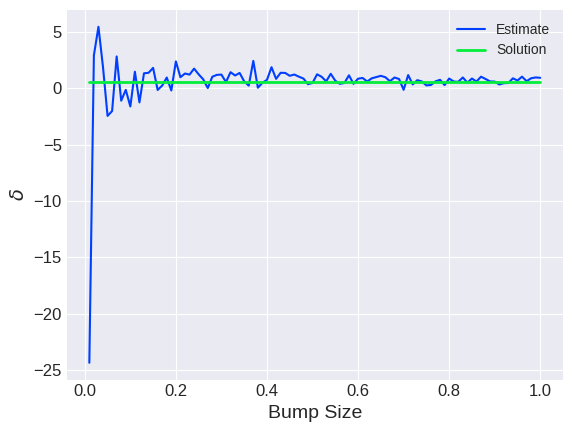

In [20]:
plt.style.use('seaborn-v0_8-bright')
plt.style.use('seaborn-v0_8-darkgrid')

# import pandas as pd

# bump_sizes = np.linspace(0.01, 1, 100)

# data = pd.read_csv('data/csv_q3_geometric_estimates_over_N.csv')

# estimates = data['EST']

plt.plot(bump_sizes, estimates, linestyle='-', linewidth=1.5, label='Estimate')
plt.plot(bump_sizes, [analytical_delta]*len(bump_sizes), linestyle='-', linewidth=2, label='Solution')
plt.xlabel('Bump Size', fontsize=14)
plt.ylabel('$\\delta$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

### *b. Random vs static seed*

From the above we infer that a bump size of approximately 0.2 is best suited for our purposes. We now compare the confidence intervals obtained for two variations of the bump-and-revalue method. Namely,
- Using different seeds for the bumped and unbumped estimate of the value, &
- Using the same seed for the bumped and unbumped estimate of the value.

In [6]:
model_params = {
    'S0': 100,
    'K': 99,
    'T': 1,
    'r': 0.06,
    'sigma': 0.2,
    'simulations': 10_000,
    'time_steps': 252
}

In [7]:
random_estimates = []
for _ in range(100):
    estimator = Delta(option=EUCall, params=model_params)
    delta = estimator.bump_and_revalue(bump_size=1, same_seed=False)
    random_estimates.append(delta)

static_estimates = []
for _ in range(100):
    estimator = Delta(option=EUCall, params=model_params)
    delta = estimator.bump_and_revalue(bump_size=1, same_seed=True)
    static_estimates.append(delta)

[ 0.08316999 -0.97811027  1.15868399 ... -0.79696973 -1.22887613
 -0.13635911]
[112.27106843 102.89944136 106.65656822 ... 106.61763312  96.50405702
  97.97975759]
[-0.11505353  0.44371278 -0.82325356 ...  0.66551298 -0.82751611
  3.47563458]
[ 96.40825934 109.90646901  89.66652348 ... 115.6317002   91.84346814
 118.87071907]
[-0.77121114  0.11611422  0.09829431 ...  0.75090203 -1.94063483
 -0.87248121]
[100.65657281 112.5378467  106.57641348 ...  99.03347424 109.04539401
 101.79753318]


[ 0.48275097 -0.39202115  0.28735716 ... -1.46949355 -0.41080252
 -0.66646182]
[ 96.95021198 104.37488769 109.31645111 ... 102.75761752 102.22970534
  95.85616076]
[-1.53943782 -0.50844628 -0.26595779 ...  0.75578797 -1.54942223
 -1.01012573]
[ 98.59701215 102.37437878  96.25082199 ...  92.92486295  94.6198312
 112.95501223]
[-0.31269664 -1.05019993 -0.70477592 ... -0.0074228  -0.17944267
  0.24364925]
[ 94.63034786 108.31390656 102.14355888 ... 103.83848995 105.91267789
 102.63582408]
[ 0.05007557 -1.31165032  0.60516321 ... -0.00954461 -0.14928511
  1.12464274]
[ 95.26942915  91.87725582  90.99583857 ... 106.25173107  96.16319858
 101.58298261]
[ 0.07123021  0.10278152  1.17315367 ... -1.01430104 -1.94422133
  0.7031141 ]
[108.68977812  96.85162227  93.99905646 ...  98.52233879  86.75467949
 111.5505119 ]
[-0.85839815 -0.3249563   0.54827152 ...  0.62698798  0.02949508
  1.36307607]
[100.35517596  93.68515006 107.79626094 ... 108.77219593 100.8465183
 107.14390858]
[-0.66760222  0.40

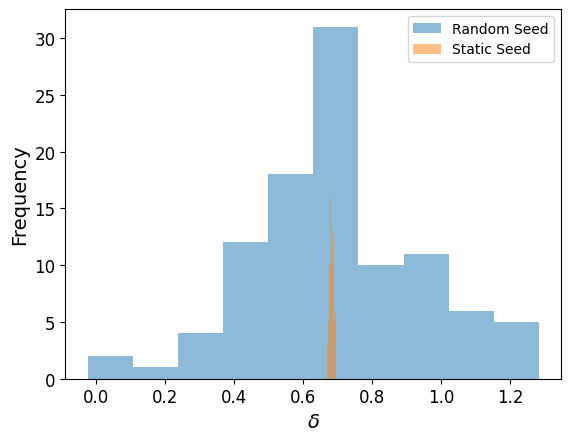

In [8]:
# plt.style.use('seaborn-v0_8-bright')
# plt.style.use('seaborn-v0_8-darkgrid')
plt.hist(random_estimates, bins=10, alpha=0.5, label='Random Seed')
plt.hist(static_estimates, bins=10, alpha=0.5, label='Static Seed')
plt.xlabel('$\\delta$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

In [9]:
mu_random, std_random = np.mean(random_estimates), np.std(random_estimates)
mu_static, std_static = np.mean(static_estimates), np.std(static_estimates)
n = len(random_estimates)

z = 1.96  # 95% CI
random_ci = z * (std_random / np.sqrt(n))
static_ci = z * (std_static / np.sqrt(n))

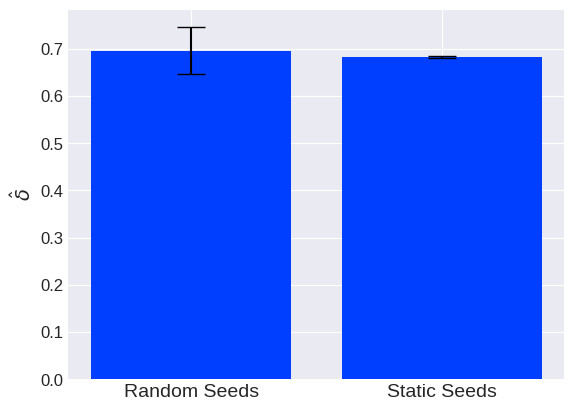

In [10]:
# plot of average delta with confidence intervals
plt.style.use('seaborn-v0_8-bright')
plt.style.use('seaborn-v0_8-darkgrid')

fig, ax = plt.subplots()

methods = ['Random Seeds', 'Static Seeds']
means = [mu_random, mu_static]
CIs = [random_ci, static_ci]

ax.bar(methods, means, yerr=CIs, capsize=10)
ax.set_ylabel('$\\hat{\\delta}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

plt.show()

## 2. Pathwise & Likelihood Ratio Methods

Consider a digital option (i.e. $\pi_0 = 1$ if $S_T > K$ at expiry or $\pi_0 = 0$ otherwise). Calculate the hedge parameter $\delta$ using the method used in question 1. 

In [ ]:
# Bump-and-Revalue for Digital Option Delta
model_params = {
    'S0': 100,
    'K': 99,
    'T': 1,
    'r': 0.06,
    'sigma': 0.2,
    'simulations': 1_000_000,
    'time_steps': 252
}

estimator = Delta(option=DigitalOption, params=model_params)

delta = estimator.bump_and_revalue(0.2, same_seed=True)

print(f"Estimated delta of digital option: {delta}")

Explain your results and use the sophisticated methods discussed in the lectures, i.e.
the pathwise and likelihood ratio methods with the application of smoothing if necessary,
to improve your results.

# **Part III** <br/> *Variance Reduction*

---

**Variance Reduction by Control Variates.** For the control variates technique an accurate estimate of the value of an option that is similar to the one that you would like to price is required. For valuation of an Asian option based on arithmetic averages one can use the value of an Asian option based on geometric averages, which is analytically solved. 

---

## **1.** Pricing Asian Options
Write a program that prices an Asian option based on geometric averages using an analytical expression.

In [4]:
model_params = {
    'S0': 100,
    'K': 99,
    'T': 1,
    'r': 0.06,
    'sigma': 0.2,
    'time_steps': 252
}

In [7]:
option = AsianOption(**model_params)
option.price_option(method='analytical')

6.474847237106069

Compare the values you obtain with the analytical expression to those obtained by using Monte-Carlo simulations.

In [8]:
pi, pi_SE = option.price_option(method='geometric')
print(f"{pi} +/- {pi_SE}")

6.29240539980554 +/- 0.2835158339924861                                                             


In [ ]:
pis, pis_SEs = [], []

Ns = np.linspace(10_000, 1_000_000, 100)
Ns = np.array(Ns, dtype=int)

for N in Ns:
    option = AsianOption(simulations=N, **model_params)
    pi, pi_SE = option.price_option(method='geometric')
    pis.append(pi)
    pis_SEs.append(pi_SE)

In [ ]:
import pandas as pd
df = pd.DataFrame({'N': Ns, 'EST': pis, 'SE': pis_SEs})
df.to_csv('csv_q3_ge_convergence.csv', index=False)

In [ ]:
# plt.style.use('seaborn-v0_8-bright')
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(6, 5))
plt.plot(Ns, pis, linestyle='-', linewidth=1.5, label='$estimate$')
plt.plot(Ns, [pi]*len(Ns), linestyle='-', linewidth=2, label='$solution$')
plt.fill_between(Ns, pis - 1.96*np.array(pis_SEs), pis + 1.96*np.array(pis_SEs), alpha=0.4)
plt.xlabel('$N$', fontsize=14)
plt.ylabel('$Price$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.show()


## **2.** Control Variates: Theory

Explain how control variates can reduce the variance in MC estimates.

## **3.** Control Variates: Implementation

Apply the control variates technique for the calculation of the value of the Asian option based on arithmetic averages.

In [5]:
option = AsianOption(simulations=100_000, **model_params)

option.control_variate_pricing()

6.7128565596603105

Study the performance of this technique for different parameter settings (number of paths, strike, number of time points used in the average etc.)

In [6]:
pis, pis_cv = [], []

Ns = np.linspace(10_000, 1_000_000, 100)
Ns = np.array(Ns, dtype=int)

for N in Ns:
    option = AsianOption(simulations=N, **model_params)
    pi, pi_SE = option.price_option(method='geometric')
    pi_cv = option.price_option(method='control_variate')
    pis.append(pi)
    pis_cv.append(pi_cv)

Progress: [████████████████████████████----------------------] 56%    

In [7]:
import pandas as pd
df = pd.DataFrame({'N': Ns, 'PI': pis, 'PI_CV': pis_cv})
df.to_csv('csv_q3_geometric_vs_control_variate.csv', index=False)

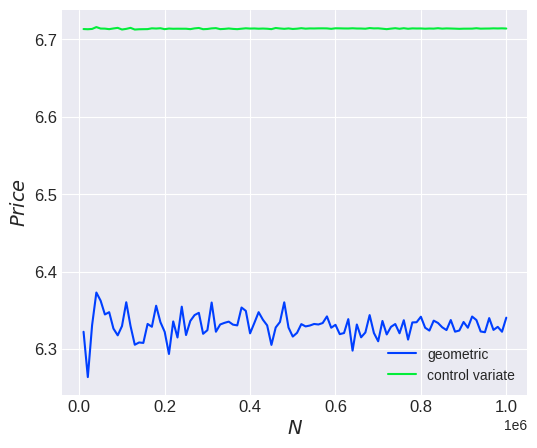

In [8]:
plt.figure(figsize=(6, 5))
plt.plot(Ns, pis, linestyle='-', linewidth=1.5, label='geometric')
plt.plot(Ns, pis_cv, linestyle='-', linewidth=1.5, label='control variate')
# plt.fill_between(Ns, pis - 1.96*np.array(pis_SEs), pis + 1.96*np.array(pis_SEs), alpha=0.4)
plt.xlabel('$N$', fontsize=14)
plt.ylabel('$Price$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.show()
